Modulo 2

In [1]:
#Misc
import os
import pickle
import importlib
import warnings
from tqdm import tqdm

#Data
import pandas as pd
import numpy as np


# Visualización
import cufflinks as cf
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #<------- ¿Usar GPU?
warnings.filterwarnings("ignore")
plt.style.use('seaborn-white')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
cf.set_config_file(theme='white',dimensions=(650,450))
cf.go_offline()

In [2]:
# Scripts personales
sys.path.insert(1, '../../Datasets/')

# String
import StringUtils 
importlib.reload(StringUtils)

import PlotUtils 
importlib.reload(PlotUtils)

import SupervisedUtils 
importlib.reload(SupervisedUtils)

<module 'SupervisedUtils' from '../../Datasets\\SupervisedUtils.py'>

In [3]:
def save_object(obj,name):
  with open(name + '.pkl', 'wb') as file:
    pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

def load_object(name):
    with open(name, 'rb') as file:
        return(pickle.load(file))

## Base módulo 1

In [4]:
TMDb = pd.read_feather('../M1/DBM1')
TMDb.head(2)

id                            genres original_language  \
0  610150  Animation-Science Fiction-Action                ja   
1  616037          Action-Adventure-Fantasy                en   

                                            overview  popularity    year  \
0  The Red Ribbon Army an evil organization that ...    7294.015  2022.0   
1  After his retirement is interrupted by Gorr th...    5207.555  2022.0   

   month   day       budget      revenue  runtime    status  \
0    6.0  11.0          0.0   68759433.0     99.0  Released   
1    7.0   6.0  250000000.0  746900000.0    119.0  Released   

                                   tagline  vote_average  vote_count  \
0  A super awakening and calamity is born.         7.330       253.0   
1                 The one is not the only.         6.766      2167.0   

                                            keywords  \
0  android-sequel-attack-based on manga-fighting-...   
1  ex-girlfriend-hero-greek mythology-sequel-supe...   

                        poster_path                     backdrop_path  
0  /rugyJdeoJm7cSJL1q4jBpTNbxyU.jpg  /ugS5FVfCI3RV0ZwZtBV3HAV75OX.jpg  
1  /pIkRyD18kl4FhoCNQuWxWu5cBLM.jpg  /vvObT0eIWGlArLQx3K5wZ0uT812.jpg

## Generación de variables

In [5]:
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
print(movies.shape)


(22880, 13)


In [6]:
movies.isna().sum().to_frame().T

id  genres  original_language  overview  popularity  year  month  budget  \
0   0       0                  0         0           0   204    204       0   

   runtime  tagline  vote_average  vote_count  keywords  
0       48     8550             0           0      5480

In [7]:
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

### Variable objetivo

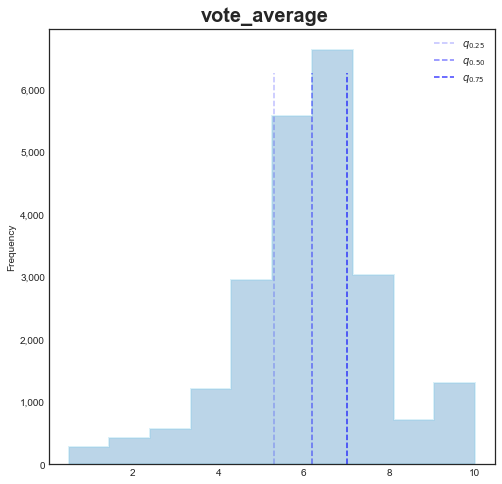

In [8]:
PlotUtils.hist(movies,'vote_average')

In [9]:
# movies['y']=pd.cut(movies['vote_average'],2)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

In [10]:
movies['y'].value_counts()

Malo     13633
Buena     9004
Name: y, dtype: int64

In [11]:
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])

### Variables independientes

In [12]:
movies.columns

Index(['id', 'genres', 'original_language', 'overview', 'popularity', 'year',
       'month', 'budget', 'runtime', 'tagline', 'vote_average', 'vote_count',
       'keywords', 'y'],
      dtype='object')

In [13]:
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X.head(2)

genres original_language  \
0  Action-Adventure-Fantasy                en   
1           Thriller-Action                en   

                                            overview    year  month  \
0  After his retirement is interrupted by Gorr th...  2022.0    7.0   
1  When danger threatens her camp the fierce and ...  2022.0    8.0   

        budget  runtime                               tagline  \
0  250000000.0    119.0              The one is not the only.   
1   65000000.0    100.0  They hunt to live. It lives to hunt.   

                                            keywords  
0  ex-girlfriend-hero-greek mythology-sequel-supe...  
1  hunter-alien life-form-prequel-alien-native am...

In [14]:
X.isna().sum().to_frame().T

genres  original_language  overview  year  month  budget  runtime  tagline  \
0       0                  0         0     0      0       0        0     8441   

   keywords  
0      5347

### Particion de los datos

In [15]:
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

## Procesamiento de variables independientes

### Variables categoricas

In [16]:
counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

X_train.head(2)

original_language                                           overview  \
19080                kn  Raghava is a fun-loving youngster who enjoys p...   
11196                en  Dr. Samantha Goodman is a beautiful young psyc...   

         year  month    budget  runtime tagline  \
19080  2012.0    9.0  550000.0    165.0    None   
11196  2005.0    3.0  500000.0     80.0    None   

                                                keywords  genre_action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_comedy  genre_drama  genre_horror  genre_otros  genre_romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_thriller  
19080               0  
11196               1

In [17]:

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])
X_test.head(2)

original_language                                           overview  \
11460                en  In the countryside the boy Alan and his friend...   
18446                en  A pansexual polyamorous trio kidnap a 'pray-th...   

         year  month     budget  runtime tagline  \
11460  2008.0    7.0  1500000.0      0.0    None   
18446  2019.0    5.0    27000.0     19.0    None   

                                    keywords  genre_action  genre_comedy  \
11460  snake-voodoo-giant snake-giant animal             0             0   
18446                                   None             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  
11460            0             1            2              0               0  
18446            0             1            0              0               1

In [18]:
counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])
X_train.head(2)

overview    year  month  \
19080  Raghava is a fun-loving youngster who enjoys p...  2012.0    9.0   
11196  Dr. Samantha Goodman is a beautiful young psyc...  2005.0    3.0   

         budget  runtime tagline  \
19080  550000.0    165.0    None   
11196  500000.0     80.0    None   

                                                keywords  genre_action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_comedy  genre_drama  genre_horror  genre_otros  genre_romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_thriller  original_language_OTROS  original_language_en  
19080               0                        1                     0  
11196               1                        0                     1

In [19]:
X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])
X_test.head(2)

overview    year  month  \
11460  In the countryside the boy Alan and his friend...  2008.0    7.0   
18446  A pansexual polyamorous trio kidnap a 'pray-th...  2019.0    5.0   

          budget  runtime tagline                               keywords  \
11460  1500000.0      0.0    None  snake-voodoo-giant snake-giant animal   
18446    27000.0     19.0    None                                   None   

       genre_action  genre_comedy  genre_drama  genre_horror  genre_otros  \
11460             0             0            0             1            2   
18446             0             1            0             1            0   

       genre_romance  genre_thriller  original_language_OTROS  \
11460              0               0                        0   
18446              0               1                        0   

       original_language_en  
11460                     1  
18446                     1

### Variables de tipo caracter

In [20]:
engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw


In [21]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_train['overview_clean']=StringUtils.remove_stopwords(X_train['overview_clean'],engstopwords)
X_train['overview_clean']=StringUtils.remove_accents(X_train['overview_clean'])

X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])
X_test['overview_clean']=StringUtils.remove_stopwords(X_test['overview_clean'],engstopwords)
X_test['overview_clean']=StringUtils.remove_accents(X_test['overview_clean'])

In [22]:
overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])

X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

In [23]:
keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))

X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

In [24]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [25]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [26]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [27]:
X_train.head(2)

year  month    budget  runtime  genre_action  genre_comedy  \
19080  2012.0    9.0  550000.0    165.0             0             1   
11196  2005.0    3.0  500000.0     80.0             0             0   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0         0.0         0.0   
11196                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080         0.0         0.0         0.0         0.0    0.206135         0.0   
11196         0.0         0.0         0.0         0.0    0.000000         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080         0.0    0.219586          0.0          0.0          0.0   
11196         0.0    0.000000          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
19080          0.0          0.0          0.0     0.000000          0.0   
11196          0.0          0.0          0.0     0.473857          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
19080          0.0     0.000000          0.0          0.0     0.164739   
11196          0.0     0.358021          0.0          0.0     0.000000   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
19080     0.355682          0.0          0.0          0.0      0.21052   
11196     0.000000          0.0          0.0          0.0      0.00000   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
19080          0.0     0.189452          0.0     0.550907      0.20605   
11196          0.0     0.000000          0.0     0.000000      0.00000   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
19080          0.0     0.000000          0.0          0.0          0.0   
11196          0.0     0.482778          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
19080          0.0          0.0          0.0     0.215457          0.0   
11196          0.0          0.0          0.0     0.000000          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
19080          0.0          0.0     0.394267          0.0          0.0   
11196          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
19080          0.0          0.0          0.0     0.196711          0.0   
11196          0.0          0.0          0.0     0.421615          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
19080     0.222513          0.0          0.0          0.0          0.0   
11196     0.000000          

In [28]:
X_test.head(2)

year  month     budget  runtime  genre_action  genre_comedy  \
11460  2008.0    7.0  1500000.0      0.0             0             0   
18446  2019.0    5.0    27000.0     19.0             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1         0.0         0.0   
18446                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460         0.0         0.0         0.0         0.0         0.0         0.0   
18446         0.0         0.0         0.0         0.0         0.0         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460    0.617602         0.0          0.0          0.0          0.0   
18446    0.000000         0.0          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
11460          0.0          0.0     0.293119          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
11460          0.0          0.0     0.272503          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
11460     0.267763          0.0          0.0          0.0     0.290782   
18446     0.000000          0.0          0.0          0.0     0.000000   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
11460     0.262136          0.0          0.0          0.0          0.0   
18446     0.000000          0.0          0.0          0.0          0.0   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
11460          0.0          0.0     0.290573          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0       

### Escalamiento

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
sc = MinMaxScaler()
sc.fit(X_train)

MinMaxScaler()

In [31]:
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# Modelado

## Modelos ocupando vectorización

### Regresión logística

#### Modelo default

In [32]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [33]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.6725781003471126
Score en test: 0.6557714958775029


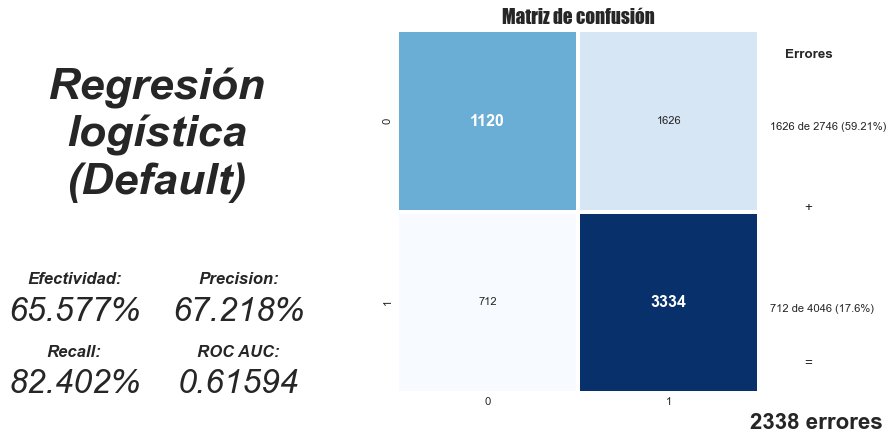

In [34]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

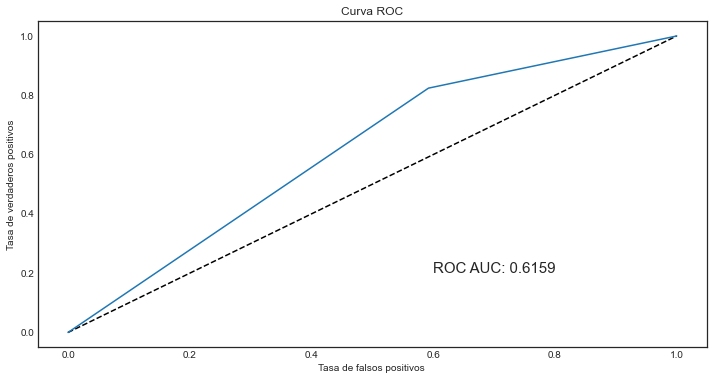

In [35]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [36]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [37]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [38]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

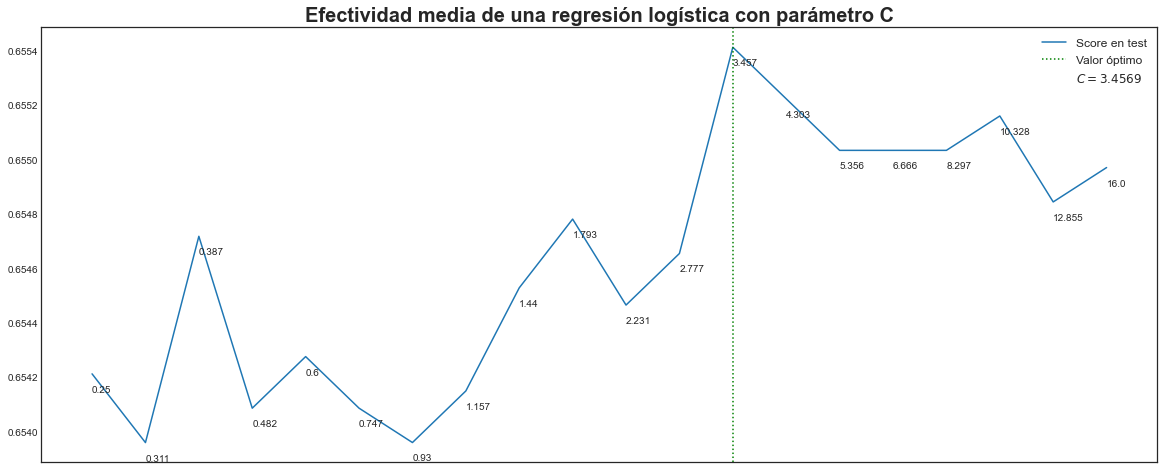

In [39]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [40]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=3.456887573126422, n_jobs=-1, random_state=12345)

In [41]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.6723887661722942
Score en test: 0.6528268551236749


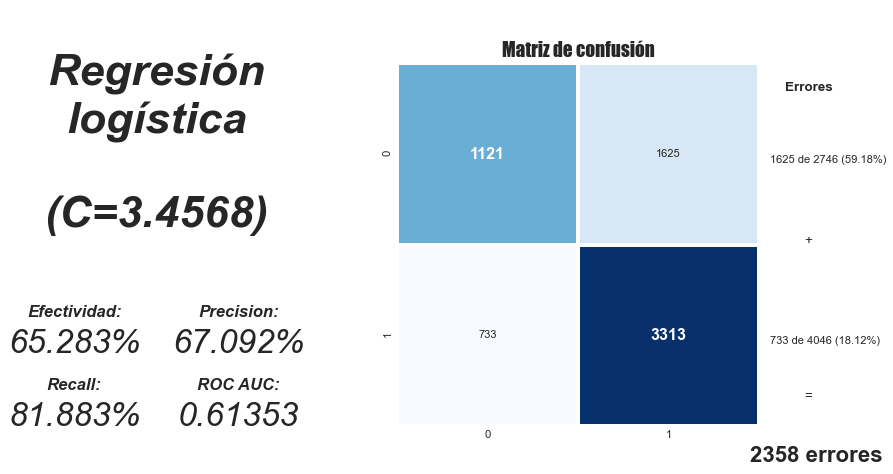

In [42]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=3.4568)',y_test,y_BestLogModel)

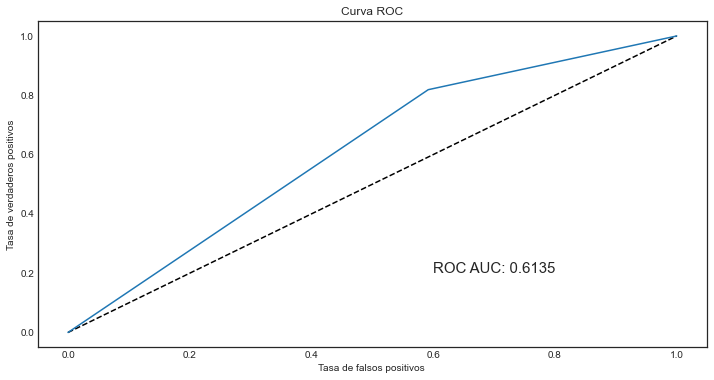

In [43]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [44]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [45]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.7563309776207303


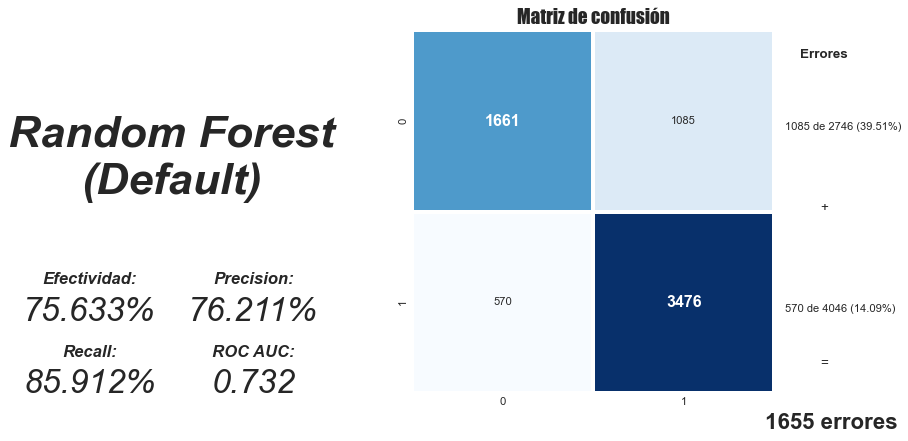

In [46]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

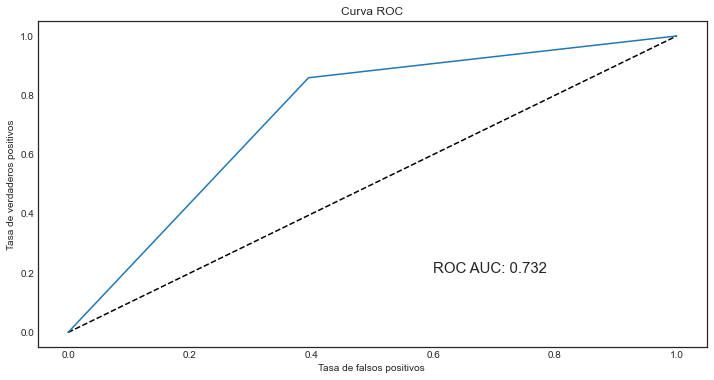

In [47]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [48]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [49]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [50]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.800) total time=   0.0s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.700) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [51]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [52]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

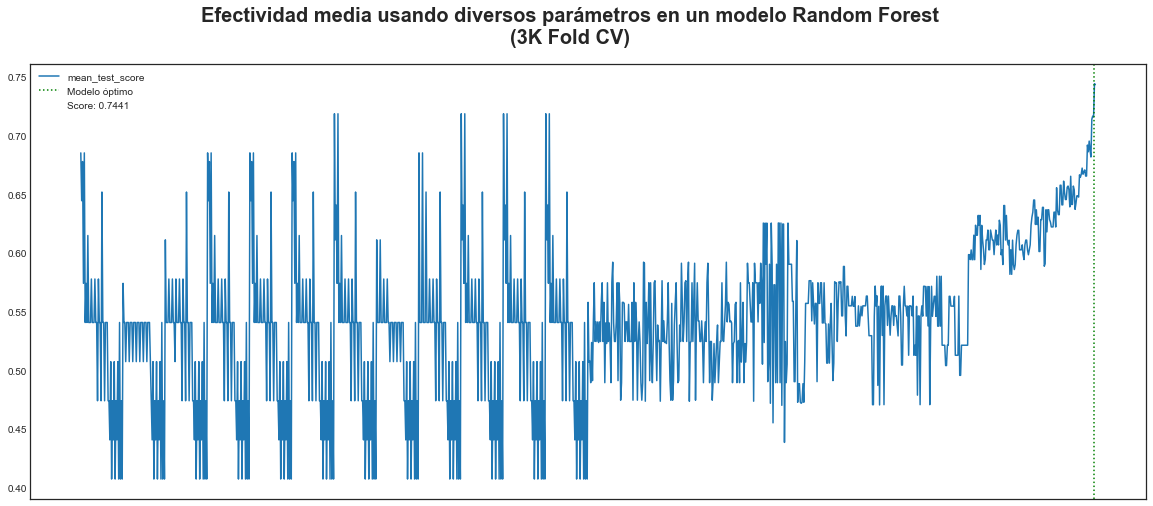

In [53]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [54]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                         2.8541
std_fit_time                                                       0.0939678
mean_score_time                                                     0.119664
std_score_time                                                    0.00741095
param_criterion                                                         gini
param_max_depth                                                         None
param_min_samples_leaf                                                     1
param_min_samples_split                                                    4
param_n_estimators                                                       200
params                     {'criterion': 'gini', 'max_depth': None, 'min_...
split0_test_score                                                   0.747266

In [55]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133         entropy            None                      1   
1134         entropy              20                      1   
1135            gini              50                      1   
1136         entropy              50                      1   
1137            gini              20                      1   
1138            gini              50                      1   
1139            gini            None                      1   
1140         entropy            None                      1   
1141         entropy            None                      2   
1142            gini              20                      1   
1143            gini              50                      1   
1144         entropy              50                      1   
1145            gini            None                      1   
1146         entropy            None                      1   
1147            gini              20                      1   
1148         entropy            None                      1   
1149            gini              50                      1   
1150            gini            None                      1   
1151            gini            None                      1   
1152            gini              50                      1   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                       2                100          1.000000   
1134                       2                100          0.958830   
1135                       6                200          0.995050   
1136                       2                200          1.000000   
1137                       4                200          0.957007   
1138                       4                200          0.998697   
1139                       4                200          0.999218   
1140                       2                200          1.000000   
1141                      10                100          0.959615   
1142                       6                200          0.951796   
1143                       4                200          0.998307   
1144                       2                200          1.000000   
1145                       4                200          0.998958   
1146                       2                200          1.000000   
1147                       4                200          0.939568   
1148                       2                200          1.000000   
1149                       4                200          0.996940   
1150                       4                200          0.998242   
1151                       4                200          0.998633   
1152                       4                200          0.995866   

      mean_test_score  
1133         0.647538  
1134         0.666494  
1135         0.664410  
1136         0.667014  
1137         0.672225  
1138         0.667011  
1139         0.669096  
1140         0.670665  
1141         0.665452  
1142         0.665448  
1143         0.691846  
1144         0.686117  
1145         0.695234  
1146         0.687420  
1147         0.681689  
1148         0.713895  
1149         0.716501  
1150         0.715849  
1151         0.744123  
1152         0.743343

#### Mejor modelo Random Forest

In [56]:
BestRFModel = SupervisedUtils.RandomForestClassifier(max_depth=50,min_samples_leaf=1,min_samples_split=4,n_estimators=200,random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(max_depth=50, min_samples_split=4, n_estimators=200,
                       n_jobs=-1, random_state=12345)

In [57]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 0.9943199747554433
Score en test: 0.7539752650176679


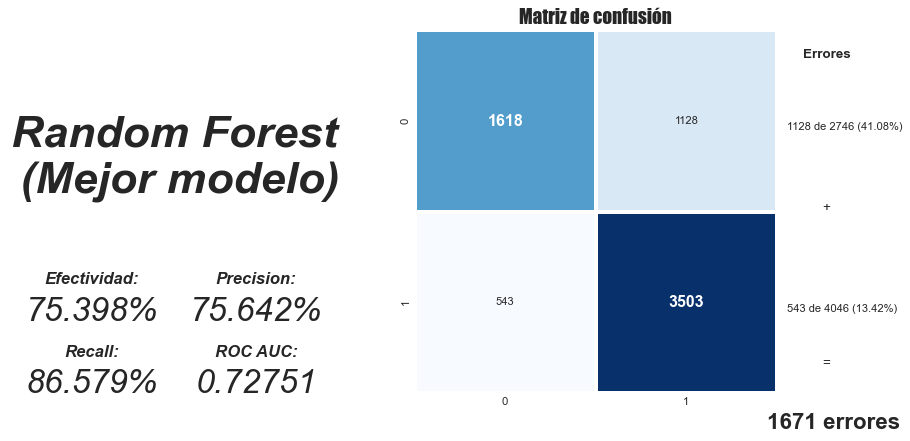

In [58]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

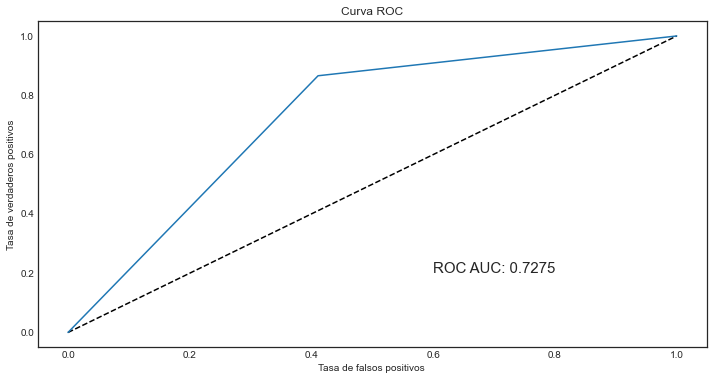

In [59]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [60]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [61]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.7558220258756706
Score en test: 0.607037691401649


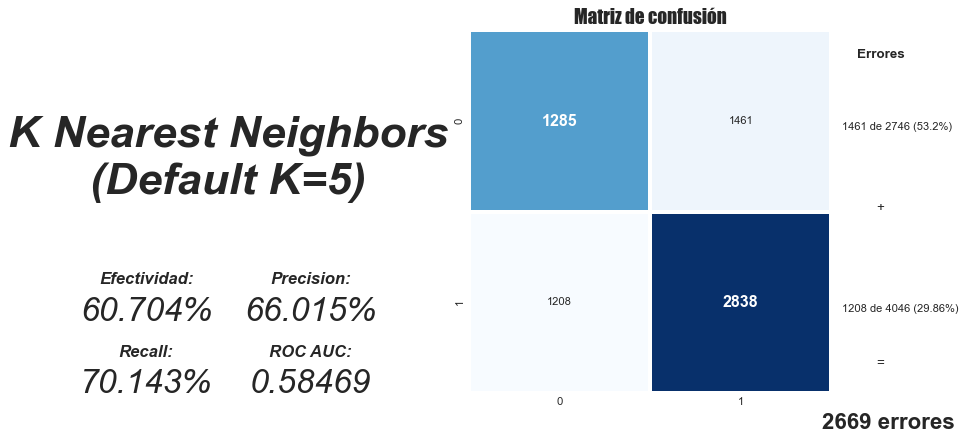

In [62]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

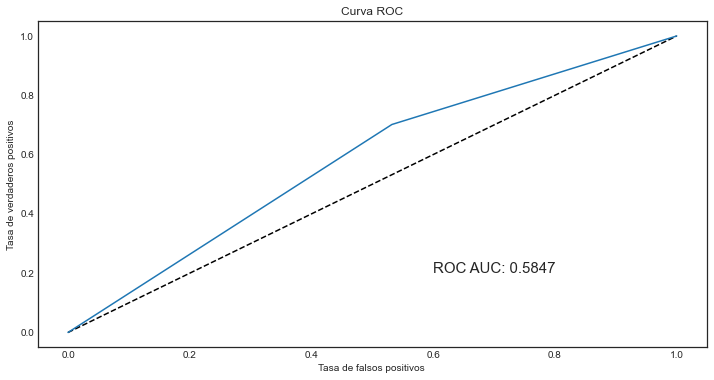

In [63]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [64]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [65]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [66]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.646, test=0.463) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.640, test=0.488) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.744, test=0.537) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [67]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [68]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

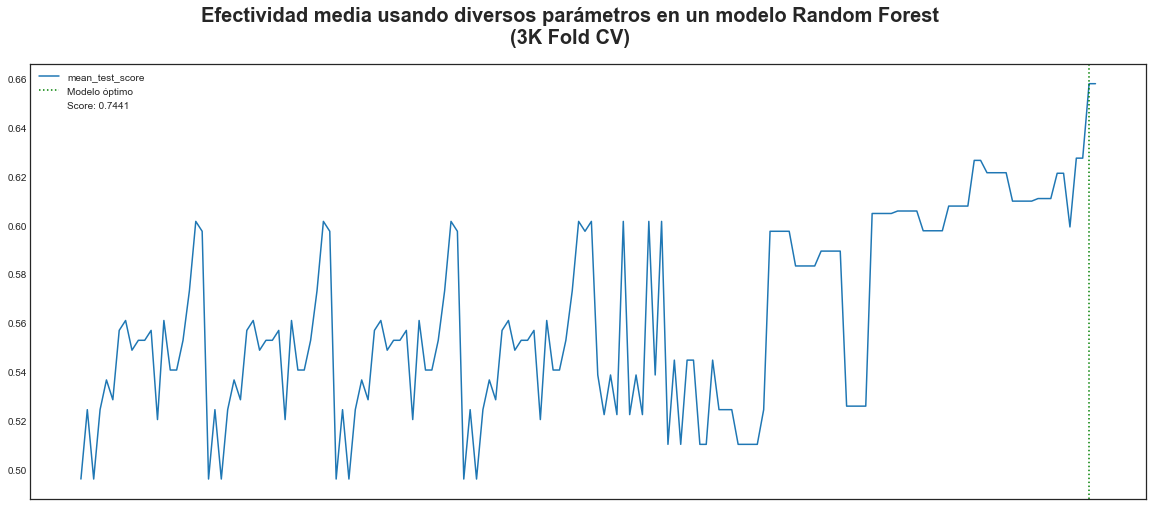

In [69]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [70]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                 0.0456696
std_fit_time                                                 0.00205823
mean_score_time                                                0.838331
std_score_time                                                0.0299393
param_leaf_size                                                      50
param_n_neighbors                                                    50
param_p                                                               2
param_weights                                                  distance
params                {'leaf_size': 50, 'n_neighbors': 50, 'p': 2, '...
split0_test_score                                              0.668058
split1_test_score                                              0.669197
split2_test_score                                              0

In [71]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140              50                50       2      distance          1.000000   
141              30                50       2      distance          1.000000   
142             100                50       2       uniform          0.646925   
143              10                50       2       uniform          0.646925   
144              50                50       2       uniform          0.646925   
145              30                50       2       uniform          0.646925   
146              10                50       1       uniform          0.662870   
147             100                50       1       uniform          0.662870   
148              30                50       1       uniform          0.662870   
149              50                50       1       uniform          0.662870   
150              10                50       2       uniform          0.642242   
151              50                50       2       uniform          0.642242   
152              30                50       2       uniform          0.642242   
153              50                50       2      distance          1.000000   
154              30                50       2      distance          1.000000   
155              30                50       2       uniform          0.619852   
156              50                50       2      distance          1.000000   
157              30                50       2      distance          1.000000   
158              50                50       2      distance          1.000000   
159              30                50       2      distance          1.000000   

     mean_test_score  
140         0.626646  
141         0.626646  
142         0.621581  
143         0.621581  
144         0.621581  
145         0.621581  
146         0.609929  
147         0.609929  
148         0.609929  
149         0.609929  
150         0.610985  
151         0.610985  
152         0.610985  
153         0.621362  
154         0.621362  
155         0.599342  
156         0.627563  
157         0.627563  
158         0.658103  
159         0.658103

#### Mejor modelo KNN

In [72]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50, weights='distance')
BestKNNModel

KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50,
                     weights='distance')

In [73]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 1.0
Score en test: 0.6709363957597173


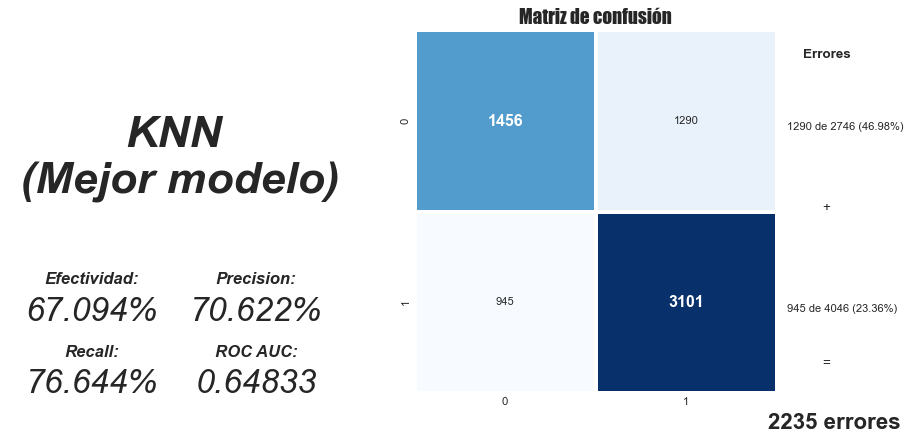

In [74]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

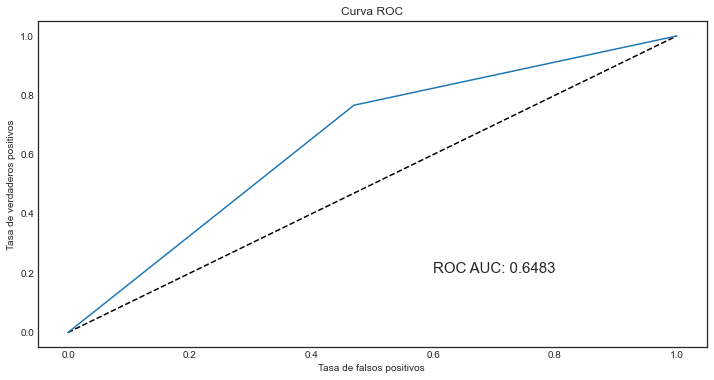

In [75]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [76]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

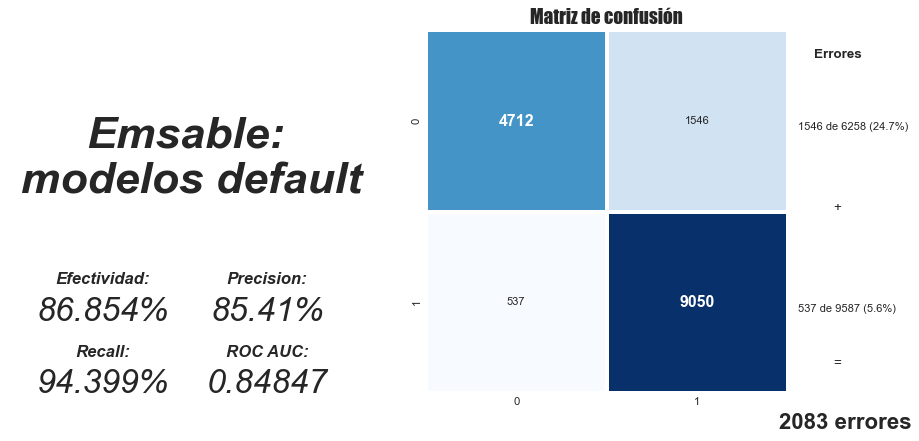

In [77]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [78]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    0                        0
8                    0              0    0                        0
9                    1              1    1                        1

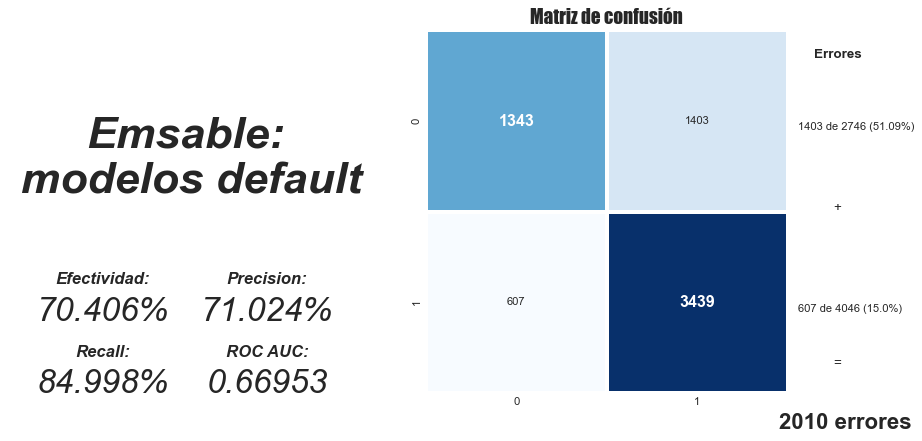

In [79]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [80]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

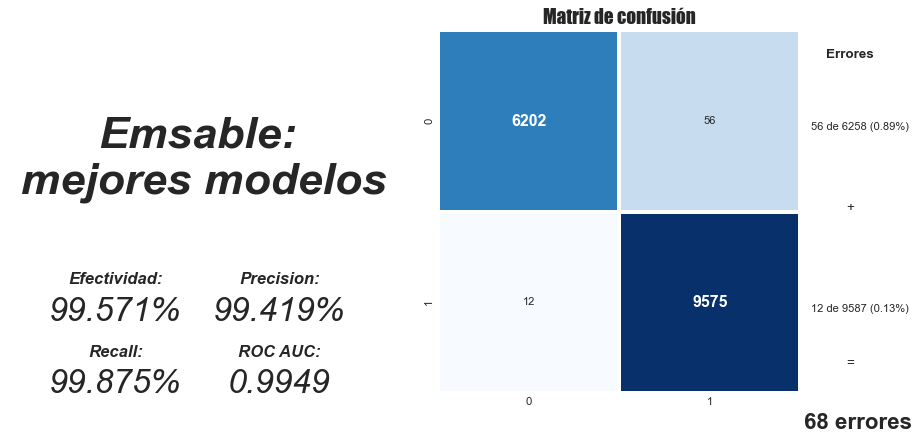

In [81]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [82]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    1                        1
8                    0              0    0                        0
9                    1              1    1                        1

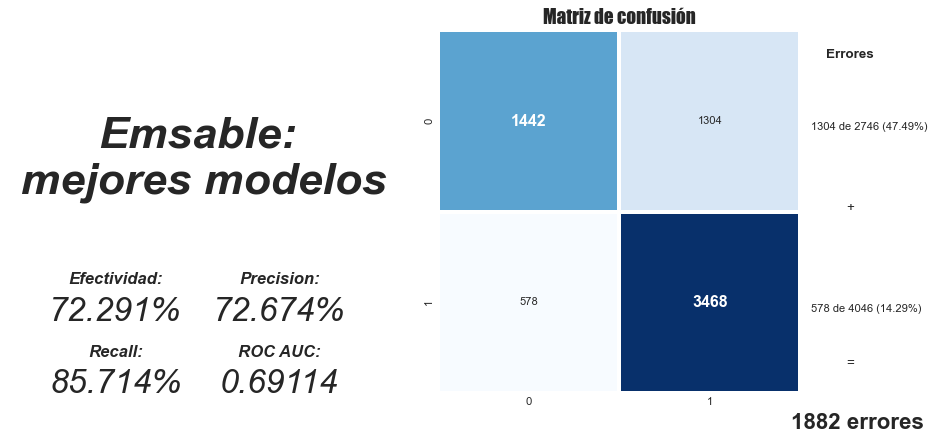

In [83]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [84]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [85]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                 0.655770        0.75633  0.607040   
Precision                   0.672180        0.76211  0.660150   
Recall                      0.824020        0.85912  0.701430   
ROC AUC - Score             0.615945        0.73200  0.584693   

                 Ensamble: Default  
Efectividad               0.704060  
Precision                 0.710240  
Recall                    0.849980  
ROC AUC - Score           0.669525

In [86]:
ModelMetricsDef_TFID=ModelMetricsDef
ModelMetricsDef_TFID.to_excel('ModelMetricsDef_TFID.xlsx')

In [87]:
# ModelMetricsDef = load_object('ModelMetricsDef_TFID.pkl')
# ModelMetricsDef_TFID=ModelMetricsDef

#### Métricas de modelos seleccionados

In [88]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_BestRFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [89]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                 0.652830       0.753980  0.670940   
Precision                   0.670920       0.756420  0.706220   
Recall                      0.818830       0.865790  0.766440   
ROC AUC - Score             0.613532       0.727507  0.648331   

                 Ensamble: Mejores modelos  
Efectividad                       0.722910  
Precision                         0.726740  
Recall                            0.857140  
ROC AUC - Score                   0.691135

In [90]:
ModelMetrics_TFID=ModelMetrics
ModelMetrics_TFID.to_excel('ModelMetrics_TFID.xlsx')

In [91]:
# ModelMetrics = load_object('ModelMetrics_TFID.pkl')
# ModelMetrics_TFID=ModelMetrics

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

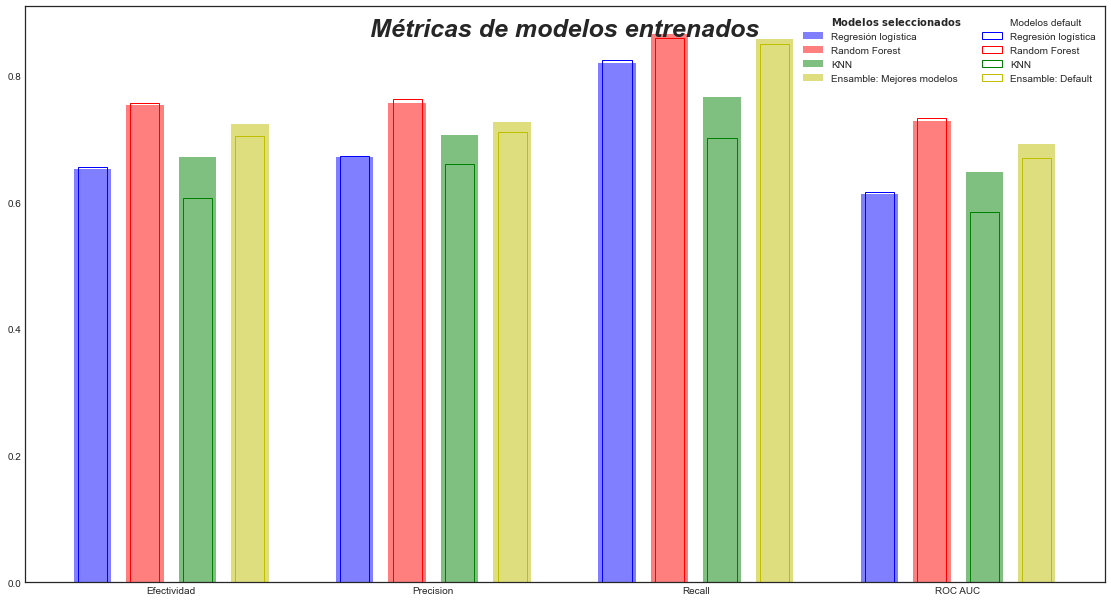

In [92]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [93]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [94]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [95]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [96]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                  0.652830      0.753980  0.670940   
Precision                    0.670920      0.756420  0.706220   
Recall                       0.818830      0.865790  0.766440   
ROC AUC - Score              0.613532      0.727507  0.648331   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.722910            0.655770       0.75633   
Precision                        0.726740            0.672180       0.76211   
Recall                           0.857140            0.824020       0.85912   
ROC AUC - Score                  0.691135            0.615945       0.73200   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.607040                  0.704060  
Precision        0.660150                  0.710240  
Recall           0.701430                  0.849980  
ROC AUC - Score  0.584693                  0.669525

## Modelos ocupando Doc2Vec

### Preprocesamiento

In [97]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [98]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)


counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw

In [99]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])

overview_tags = [TaggedDocument(words = x.split(), tags = [y]) for x,y in zip(X_train['overview_clean'],y_train)]

print('Entrenando modelo d2v_overview')
d2v_overview = Doc2Vec(vector_size=100, min_count=1, epochs=10)
d2v_overview.build_vocab(overview_tags)
d2v_overview.train(overview_tags, total_examples=d2v_overview.corpus_count, epochs=d2v_overview.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(overview_tags):
    v = d2v_overview.infer_vector(t[0])
    auxlist.append(v)

X_overview_train=pd.DataFrame(auxlist)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['overview_clean']):
    v = d2v_overview.infer_vector(t.split())
    auxlist.append(v)
    
X_overview_test=pd.DataFrame(auxlist)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]
X_overview_test.index = X_test.index

Entrenando modelo d2v_overview


  0%|          | 74/15845 [00:00<00:21, 739.96it/s]

Creando matriz de entrenamiento


  1%|          | 67/6792 [00:00<00:10, 669.97it/s]

Creando matriz de validacion


100%|██████████| 6792/6792 [00:09<00:00, 688.28it/s]


In [100]:
keywords_tags = [TaggedDocument(words = x.split('-'), tags = [y]) for x,y in zip(X_train['keywords'].astype(str),y_train)]

print('Entrenando modelo d2v_keywords')
d2v_keywords = Doc2Vec(vector_size=100, min_count=1, epochs=10)
d2v_keywords.build_vocab(keywords_tags)
d2v_keywords.train(keywords_tags, total_examples=d2v_keywords.corpus_count, epochs=d2v_keywords.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(keywords_tags):
    v = d2v_keywords.infer_vector(t[0])
    auxlist.append(v)

X_keywords_train=pd.DataFrame(auxlist)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['keywords'].astype(str)):
    v = d2v_keywords.infer_vector(t.split('-'))
    auxlist.append(v)
    
X_keywords_test=pd.DataFrame(auxlist)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]
X_keywords_test.index = X_test.index

Entrenando modelo d2v_keywords


  1%|          | 141/15845 [00:00<00:11, 1409.91it/s]

Creando matriz de entrenamiento


  2%|▏         | 144/6792 [00:00<00:04, 1439.92it/s]

Creando matriz de validacion


100%|██████████| 6792/6792 [00:04<00:00, 1413.53it/s]


In [101]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [102]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [103]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [104]:
X_train

year  month      budget  runtime  genre_action  genre_comedy  \
19080  2012.0    9.0    550000.0    165.0             0             1   
11196  2005.0    3.0    500000.0     80.0             0             0   
15488  2016.0    8.0     25000.0     62.0             0             0   
1477   1997.0    3.0  10000000.0     99.0             1             0   
12316  2019.0   10.0   1500000.0     98.0             0             0   
...       ...    ...         ...      ...           ...           ...   
11689  2009.0    9.0     31192.0     89.0             1             1   
19876  2017.0    4.0    179000.0     29.0             0             0   
2177   2018.0    7.0  75000000.0    113.0             0             1   
11749  2005.0   10.0   6500000.0    100.0             0             0   
20962  2006.0    1.0      5000.0      7.0             0             0   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   
15488            0             0            1              0               0   
1477             0             0            4              0               1   
12316            0             1            0              0               0   
...            ...           ...          ...            ...             ...   
11689            1             0            0              0               0   
19876            0             1            1              0               0   
2177             0             0            0              1               0   
11749            1             0            1              0               0   
20962            1             0            0              0               0   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0   -0.183084   -0.443962   
11196                        0                     1   -0.022443   -0.181603   
15488                        0                     1   -0.105431   -0.108782   
1477                         0                     1   -0.111953   -0.167597   
12316                        0                     1   -0.515426   -0.229336   
...                        ...                   ...         ...         ...   
11689                        0                     1   -0.204077   -0.309569   
19876                        0                     1    0.025202   -0.129875   
2177                         0                     1   -0.114559   -0.062487   
11749                        0                     1   -0.389105   -0.332213   
20962                        0                     1   -0.068593   -0.069919   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080   -0.852251    0.520506   -0.447644   -0.314145    0.069846    0.109619   
11196   -0.319593    0.199114   -0.174244   -0.148340    0.044460    0.130432   
15488   -0.186761    0.259504   -0.051542   -0.021146   -0.022652    0.109091   
1477    -0.399978    0.286663   -0.300718   -0.179320   -0.028567    0.181320   
12316   -0.281003    0.382798   -0.434374   -0.173906    0.024848    0.328457   
...           ...         ...         ...         ...         ...         ...   
11689   -0.415063    0.379864   -0.173092   -0.188437    0.046870    0.243442   
19876   -0.147076    0.160441   -0.132443   -0.122903   -0.003242    0.083026   
2177    -0.253324    0.216594   -0.112780   -0.063669   -0.001353    0.157596   
11749   -0.616151    0.922198   -0.469942   -0.150416   -0.142963    0.141929   
20962   -0.137160    0.128420   -0.058827   -0.096409    0.078597    0.060380   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080    0.191250    0.074626    -0.164728    -0.000100    -0.111833   
11196   -0.037023   -0.156180    -0.106641    -0.073202    -0.142345   
15488   -0.020498   -

In [105]:
X_test

year  month      budget  runtime  genre_action  genre_comedy  \
11460  2008.0    7.0   1500000.0      0.0             0             0   
18446  2019.0    5.0     27000.0     19.0             0             1   
18265  1944.0    4.0        22.0     11.0             0             1   
10081  2005.0    9.0   2500000.0    158.0             0             1   
20590  2017.0   12.0      3330.0    114.0             1             0   
...       ...    ...         ...      ...           ...           ...   
22040  2019.0   12.0      2000.0     30.0             0             0   
5050   2016.0    1.0    350000.0     76.0             0             0   
11102  2008.0    1.0    560000.0    102.0             0             1   
4408   2007.0   10.0  45000000.0    139.0             0             0   
5723   2019.0   12.0   6837995.0     90.0             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   
18265            0             0            1              0               0   
10081            1             0            0              1               0   
20590            1             0            0              0               0   
...            ...           ...          ...            ...             ...   
22040            1             0            1              0               0   
5050             0             1            0              0               1   
11102            1             0            0              1               0   
4408             1             0            0              1               0   
5723             0             0            0              0               0   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1   -0.358105   -0.415554   
18446                        0                     1   -0.017248   -0.076271   
18265                        0                     1   -0.038696   -0.069673   
10081                        1                     0   -0.050367   -0.069695   
20590                        0                     1   -0.244273   -0.169495   
...                        ...                   ...         ...         ...   
22040                        0                     1   -0.049732   -0.046654   
5050                         1                     0   -0.145639   -0.129923   
11102                        1                     0   -0.330683   -0.209188   
4408                         0                     1   -0.193680   -0.080393   
5723                         1                     0   -0.141239   -0.042473   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460   -0.487165    0.489600   -0.281473   -0.172391    0.070007    0.148026   
18446   -0.151398    0.138712   -0.063754   -0.040283    0.010310    0.013988   
18265   -0.162224    0.048295    0.053382   -0.018365    0.020037    0.070366   
10081   -0.129084    0.284858   -0.079946   -0.037628   -0.024964    0.152658   
20590   -0.122247    0.413076   -0.121272   -0.023252    0.062866    0.124905   
...           ...         ...         ...         ...         ...         ...   
22040   -0.130385    0.063364   -0.044573   -0.031786    0.004484    0.025209   
5050    -0.111052    0.317096   -0.151321   -0.170728   -0.048166    0.124692   
11102   -0.276146    0.387816   -0.124799    0.038469   -0.091247    0.100028   
4408    -0.173127    0.287109   -0.057096    0.026813   -0.063880    0.141688   
5723    -0.235762    0.165433   -0.145318   -0.029248   -0.094209    0.113746   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460   -0.231021    0.047009    -0.272295    -0.119270     0.061481   
18446    0.017104   -0.000983     0.001208     0.015417     0.015221   
18265   -0.013851   -

In [106]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Regresión logística

#### Modelo default

In [107]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [108]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.8973177658567372
Score en test: 0.6727031802120141


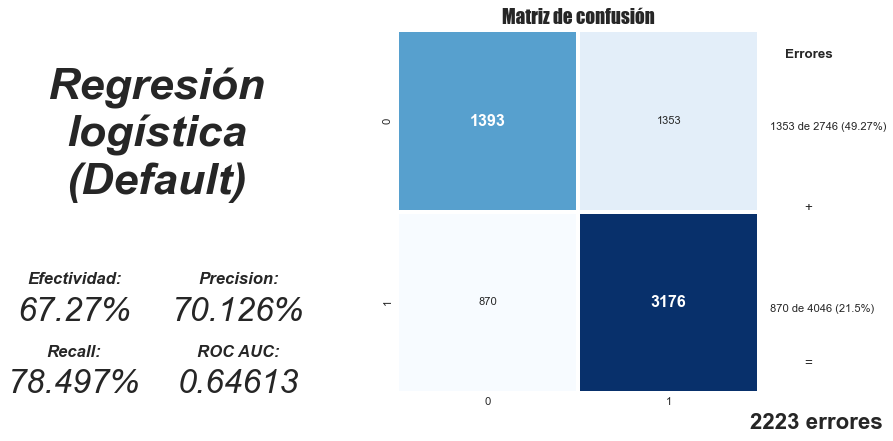

In [109]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

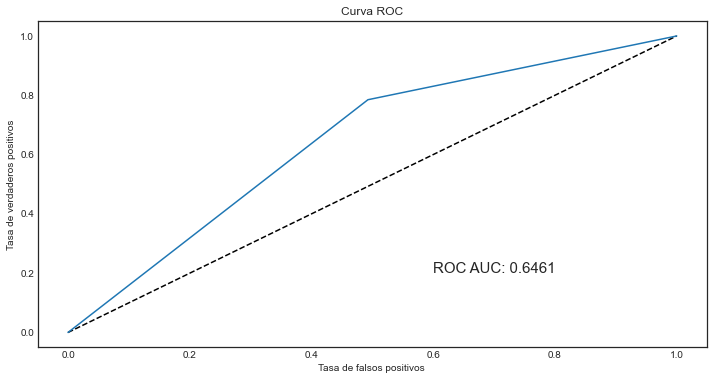

In [110]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [111]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [112]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [113]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

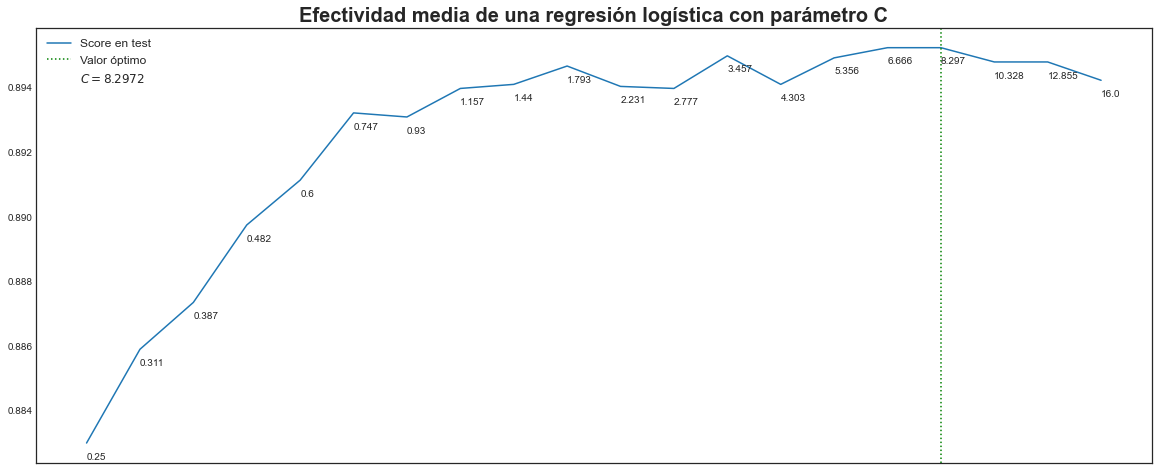

In [114]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [171]:
BestLogModel = SupervisedUtils.LogisticRegression(C=8.297240355569535,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=8.297240355569535, n_jobs=-1, random_state=12345)

In [172]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.8973808772483434
Score en test: 0.6669611307420494


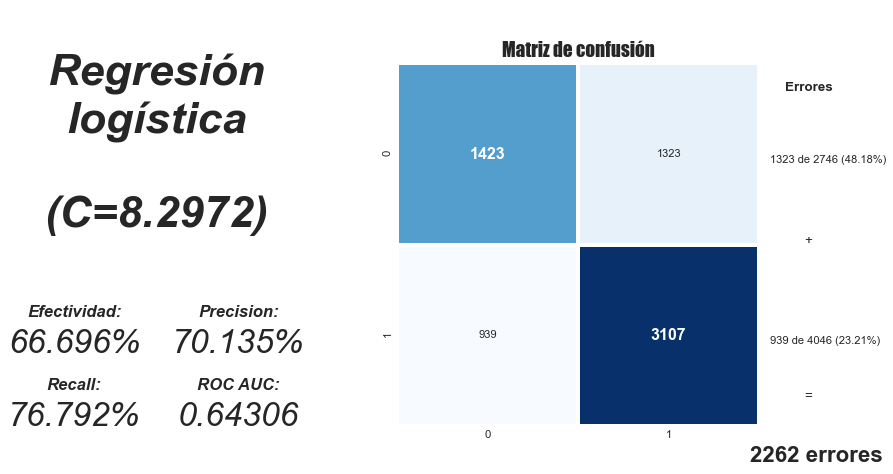

In [173]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=8.2972)',y_test,y_BestLogModel)

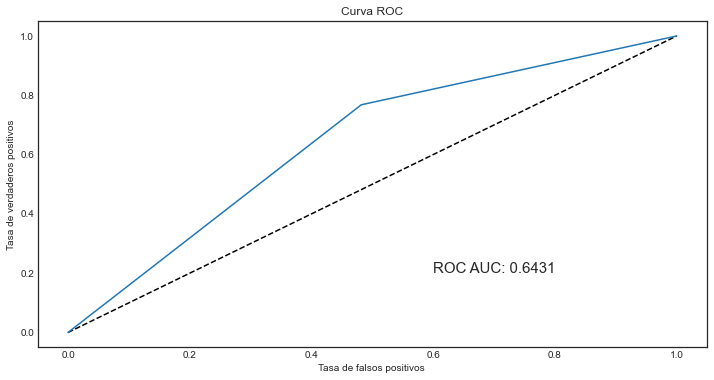

In [174]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [119]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [120]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.6824204946996466


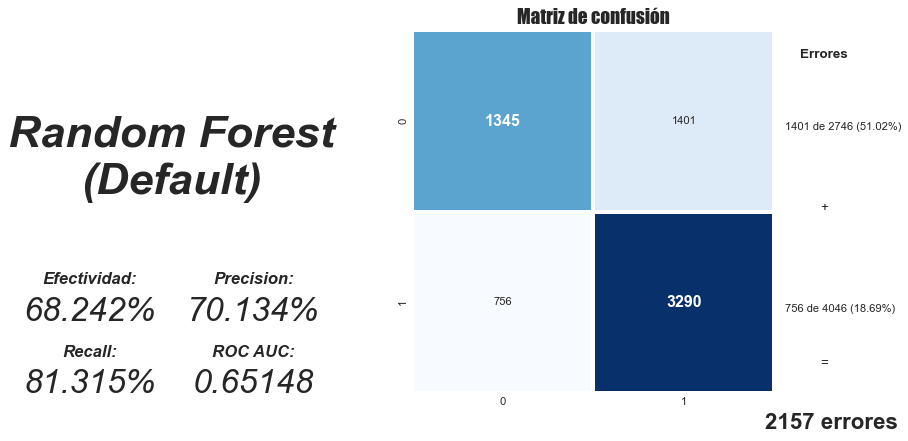

In [121]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

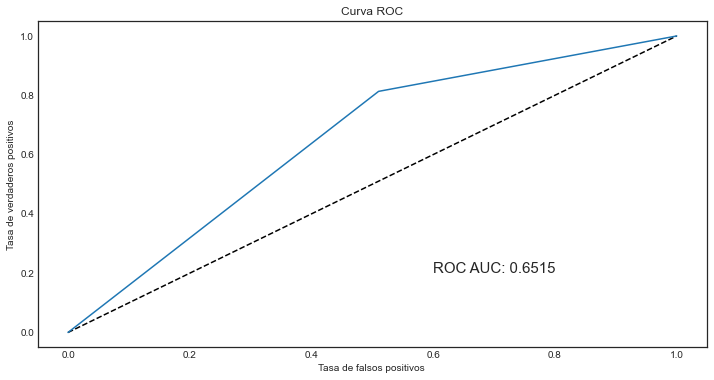

In [122]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [123]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [124]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [125]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.947, test=0.700) total time=   0.0s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.895, test=0.500) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [126]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [127]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

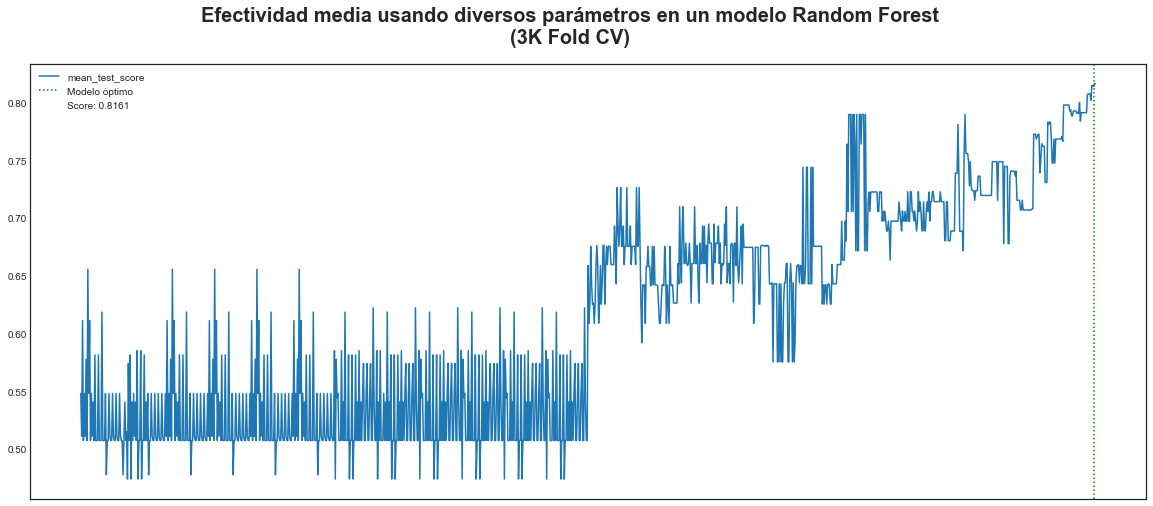

In [128]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [129]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                        3.24135
std_fit_time                                                       0.0119745
mean_score_time                                                    0.0369962
std_score_time                                                   2.83664e-06
param_criterion                                                      entropy
param_max_depth                                                         None
param_min_samples_leaf                                                     3
param_min_samples_split                                                    2
param_n_estimators                                                        50
params                     {'criterion': 'entropy', 'max_depth': None, 'm...
split0_test_score                                                   0.808594

In [130]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133            gini              50                      1   
1134            gini            None                      1   
1135            gini              10                      1   
1136         entropy              20                      3   
1137         entropy              50                      3   
1138         entropy            None                      3   
1139         entropy              50                      3   
1140         entropy            None                      3   
1141         entropy              20                      3   
1142         entropy              50                      3   
1143         entropy              50                      3   
1144         entropy            None                      3   
1145         entropy              20                      3   
1146         entropy              50                      3   
1147            gini            None                      1   
1148         entropy            None                      3   
1149         entropy              50                      3   
1150         entropy              20                      3   
1151         entropy            None                      3   
1152         entropy              50                      3   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                       4                100          1.000000   
1134                       2                 50          0.999739   
1135                       6                100          0.989057   
1136                       6                 50          0.993746   
1137                       6                 50          0.993746   
1138                       6                 50          0.993746   
1139                       4                 50          0.993746   
1140                       2                 50          0.993746   
1141                       2                 50          0.993746   
1142                       2                 50          0.993746   
1143                       4                 50          0.995572   
1144                       2                 50          0.995572   
1145                       2                 50          0.995702   
1146                       2                 50          0.995572   
1147                       2                 50          0.999739   
1148                       2                 50          0.996419   
1149                       2                 50          0.996419   
1150                       2                 50          0.996223   
1151                       2                 50          0.995898   
1152                       2                 50          0.995898   

      mean_test_score  
1133         0.790416  
1134         0.799899  
1135         0.783743  
1136         0.791031  
1137         0.791031  
1138         0.791031  
1139         0.791031  
1140         0.791031  
1141         0.791031  
1142         0.791031  
1143         0.806981  
1144         0.806981  
1145         0.807502  
1146         0.806981  
1147         0.801772  
1148         0.814430  
1149         0.814430  
1150         0.813779  
1151         0.816134  
1152         0.816134

#### Mejor modelo Random Forest

In [131]:
BestRFModel = SupervisedUtils.RandomForestClassifier(**rfbest['params'],random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(criterion='entropy', min_samples_leaf=3, n_estimators=50,
                       n_jobs=-1, random_state=12345)

In [132]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 0.9957084253707794
Score en test: 0.6802120141342756


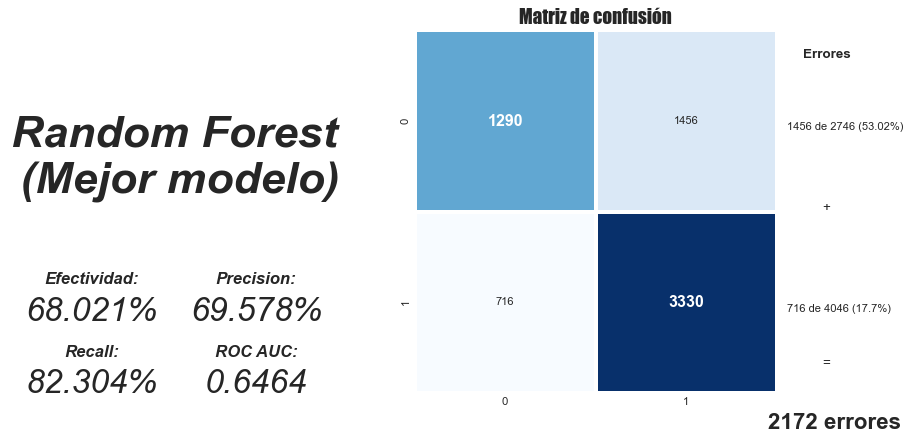

In [133]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

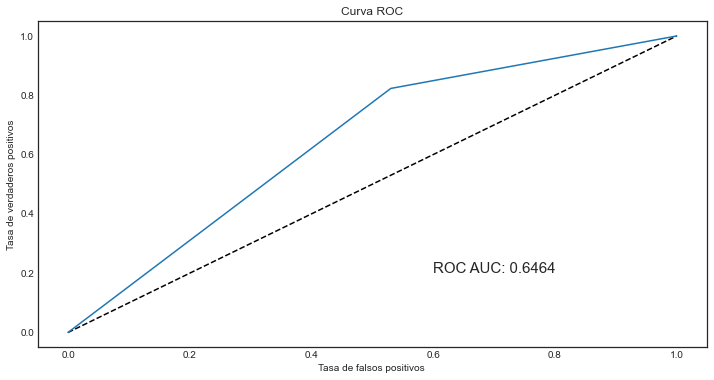

In [134]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [135]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [136]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.8452508677816346
Score en test: 0.6657832744405182


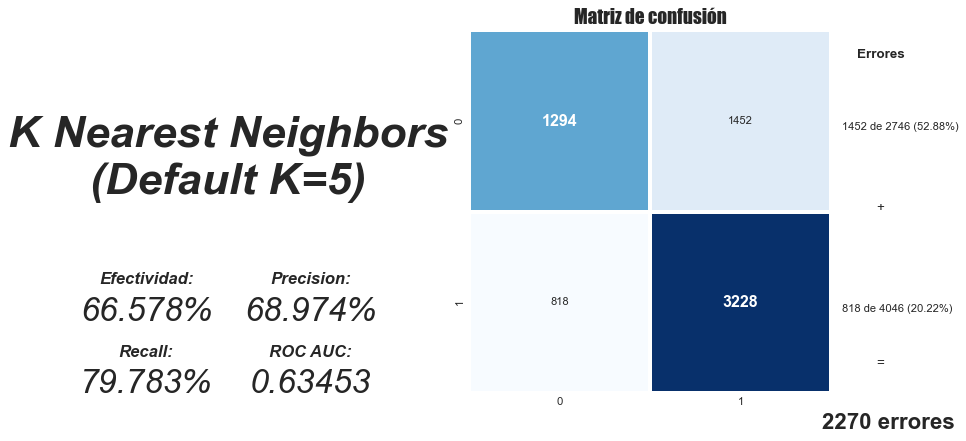

In [137]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

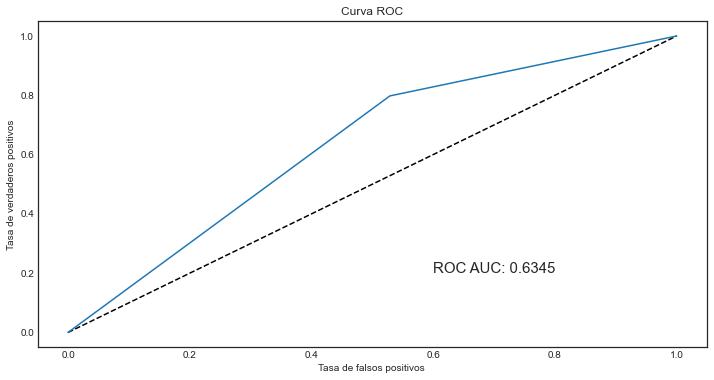

In [138]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [139]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [140]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [141]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.829, test=0.671) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.811, test=0.549) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.823, test=0.634) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [142]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [143]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

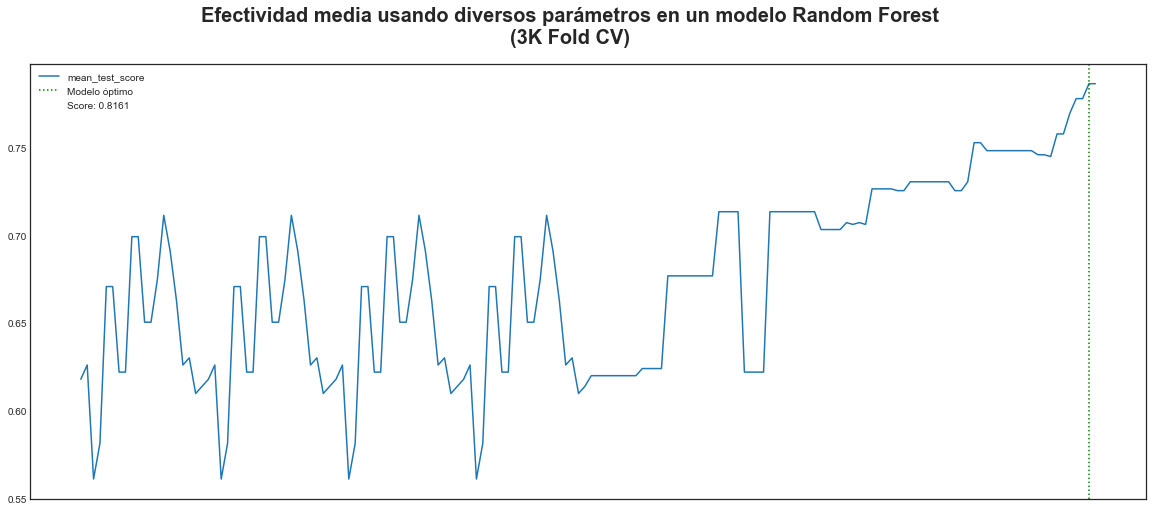

In [144]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [145]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                 0.0456657
std_fit_time                                                 0.00170086
mean_score_time                                                 3.84267
std_score_time                                               0.00612775
param_leaf_size                                                     100
param_n_neighbors                                                    10
param_p                                                               1
param_weights                                                  distance
params                {'leaf_size': 100, 'n_neighbors': 10, 'p': 1, ...
split0_test_score                                               0.79237
split1_test_score                                              0.783261
split2_test_score                                              0

In [146]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140             100                10       1      distance          1.000000   
141              10                10       1      distance          1.000000   
142              30                 7       1      distance          1.000000   
143             100                 7       1       uniform          0.808403   
144              10                 7       1      distance          1.000000   
145              10                 7       1       uniform          0.808403   
146              50                 7       1       uniform          0.808403   
147              50                 7       1      distance          1.000000   
148             100                 7       1      distance          1.000000   
149              30                 7       1       uniform          0.808403   
150              50                 7       1      distance          1.000000   
151             100                 7       1      distance          1.000000   
152              30                 7       1       uniform          0.827765   
153             100                10       1      distance          1.000000   
154              10                10       1      distance          1.000000   
155             100                 7       1      distance          1.000000   
156             100                10       1      distance          1.000000   
157              10                10       1      distance          1.000000   
158             100                10       1      distance          1.000000   
159              10                10       1      distance          1.000000   

     mean_test_score  
140         0.752786  
141         0.752786  
142         0.748227  
143         0.748227  
144         0.748227  
145         0.748227  
146         0.748227  
147         0.748227  
148         0.748227  
149         0.748227  
150         0.745887  
151         0.745887  
152         0.744875  
153         0.757783  
154         0.757783  
155         0.769552  
156         0.777904  
157         0.777904  
158         0.786410  
159         0.786410

#### Mejor modelo KNN

In [147]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(**knnbest['params'],n_jobs=-1)
BestKNNModel

KNeighborsClassifier(leaf_size=100, n_jobs=-1, n_neighbors=10, p=1,
                     weights='distance')

In [148]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 1.0
Score en test: 0.6784452296819788


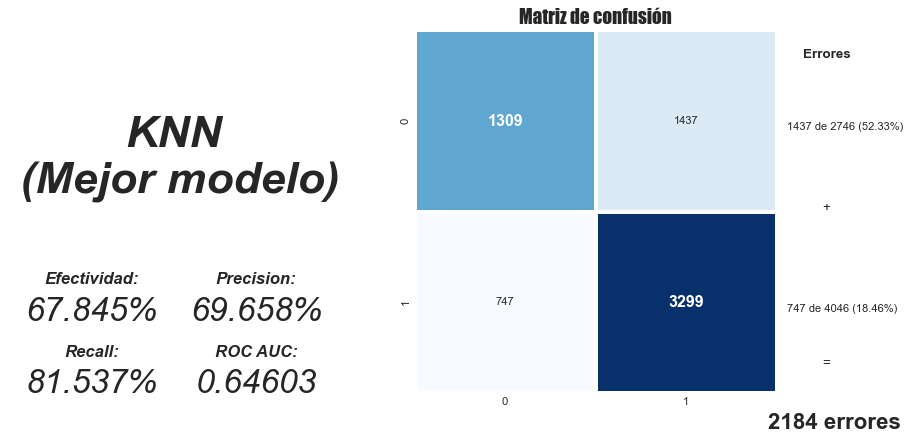

In [149]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

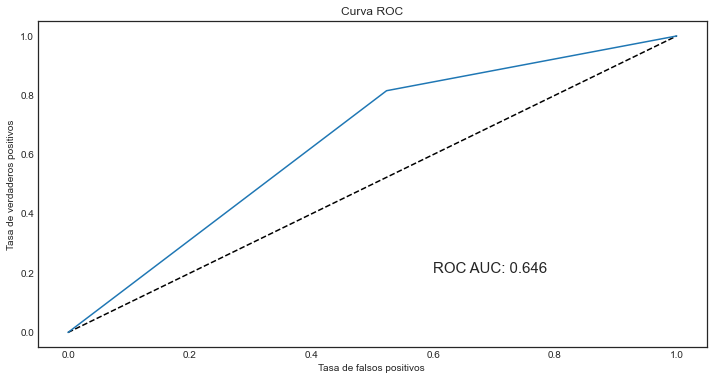

In [150]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [151]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    0              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

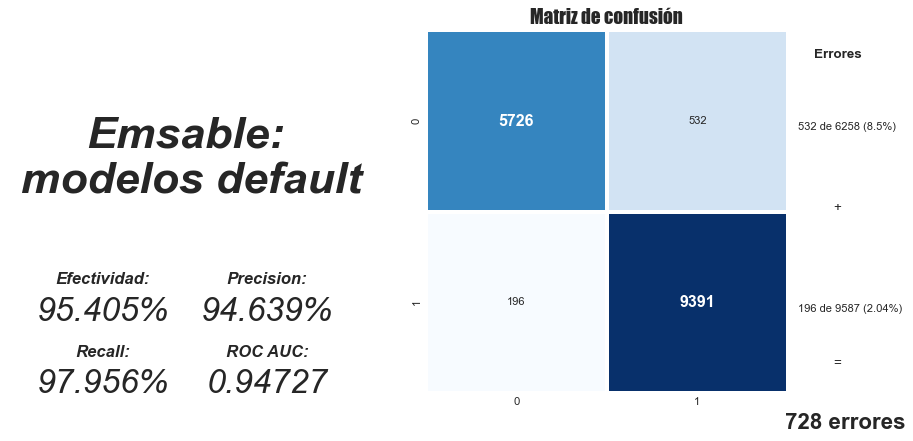

In [152]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [153]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    0              1    1                        1
4                    1              1    0                        1
5                    0              1    1                        1
6                    0              1    1                        1
7                    0              0    0                        0
8                    0              0    1                        0
9                    1              1    1                        1

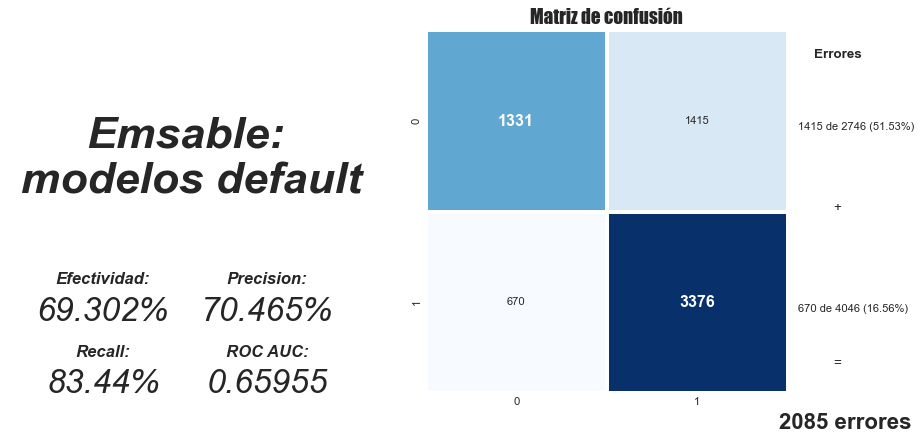

In [154]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [155]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    0              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

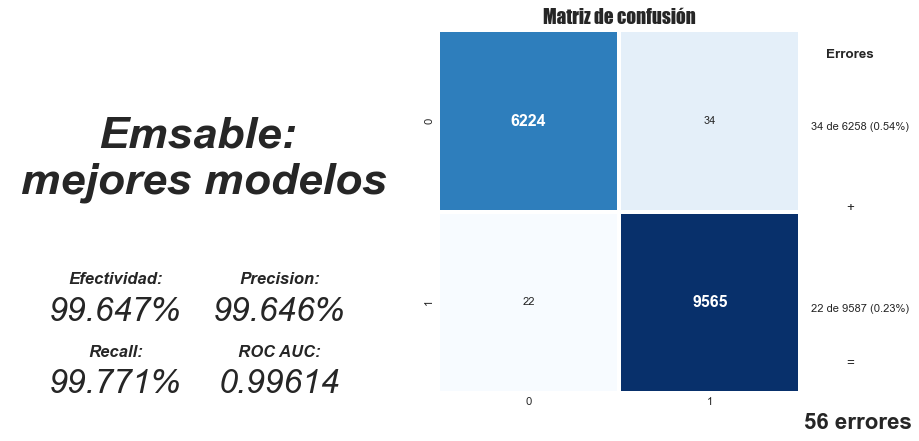

In [156]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [157]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    0              1    1                        1
4                    1              1    0                        1
5                    0              1    1                        1
6                    0              1    1                        1
7                    0              0    0                        0
8                    0              1    1                        1
9                    1              1    1                        1

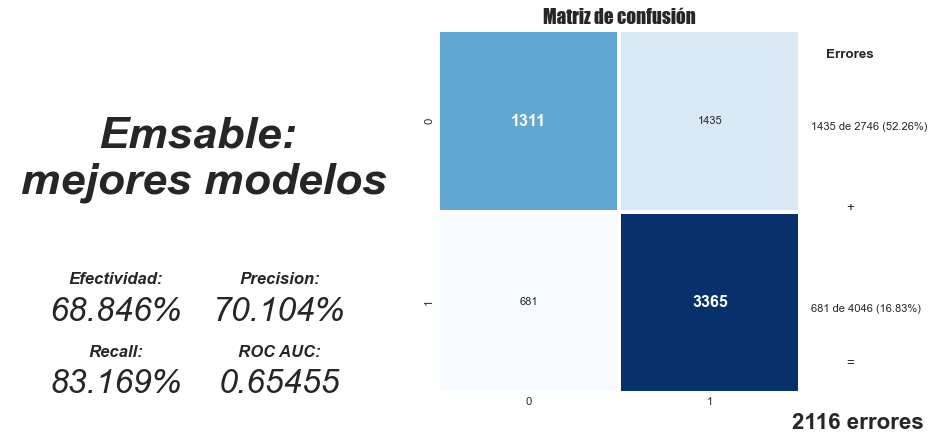

In [158]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [159]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [160]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                 0.672700       0.682420  0.665780   
Precision                   0.701260       0.701340  0.689740   
Recall                      0.784970       0.813150  0.797830   
ROC AUC - Score             0.646128       0.651476  0.634528   

                 Ensamble: Default  
Efectividad               0.693020  
Precision                 0.704650  
Recall                    0.834400  
ROC AUC - Score           0.659555

In [161]:
ModelMetricsDef_d2v=ModelMetricsDef
ModelMetricsDef_d2v.to_excel('ModelMetricsDef_d2v.xlsx')

#### Métricas de modelos seleccionados

In [162]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_BestRFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [163]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                 0.666960       0.680210  0.678450   
Precision                   0.701350       0.695780  0.696580   
Recall                      0.767920       0.823040  0.815370   
ROC AUC - Score             0.643064       0.646405  0.646033   

                 Ensamble: Mejores modelos  
Efectividad                       0.688460  
Precision                         0.701040  
Recall                            0.831690  
ROC AUC - Score                   0.654554

In [164]:
ModelMetrics_d2v=ModelMetrics
ModelMetrics_d2v.to_excel('ModelMetrics_d2v.xlsx')

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

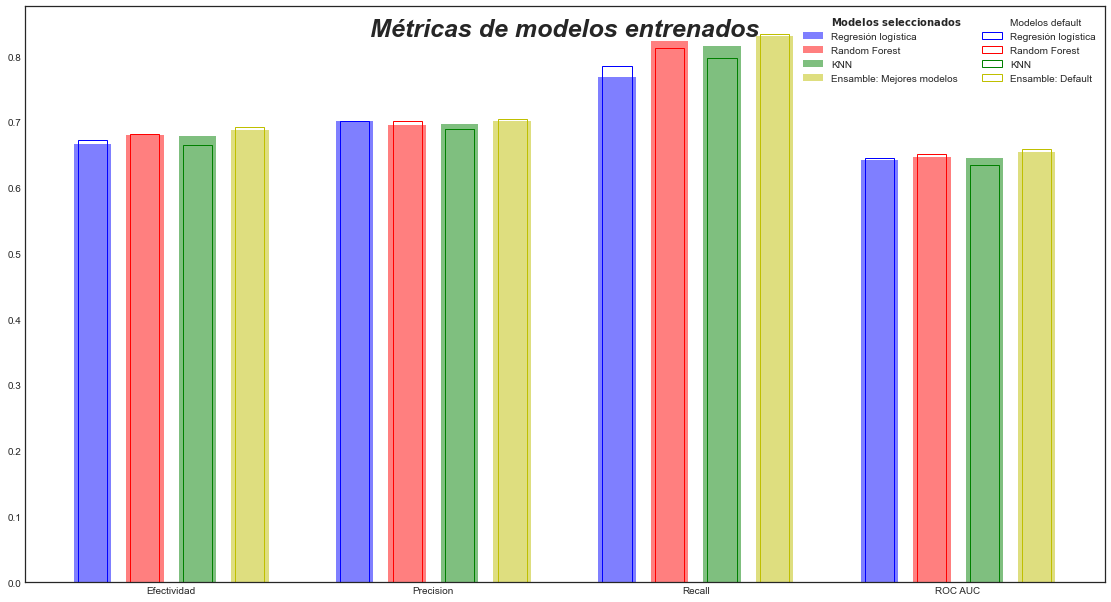

In [165]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [166]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [167]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [168]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [169]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                  0.666960      0.680210  0.678450   
Precision                    0.701350      0.695780  0.696580   
Recall                       0.767920      0.823040  0.815370   
ROC AUC - Score              0.643064      0.646405  0.646033   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.688460            0.672700      0.682420   
Precision                        0.701040            0.701260      0.701340   
Recall                           0.831690            0.784970      0.813150   
ROC AUC - Score                  0.654554            0.646128      0.651476   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.665780                  0.693020  
Precision        0.689740                  0.704650  
Recall           0.797830                  0.834400  
ROC AUC - Score  0.634528                  0.659555

## TF-IDF vs Doc2Vec

In [ ]:
ModelMetricsDef_TFID = pd.read_excel('ModelMetricsDef_TFID.xlsx',index_col=0)
ModelMetricsDef_d2v = pd.read_excel('ModelMetricsDef_d2v.xlsx',index_col=0)
ModelMetrics_TFID = pd.read_excel('ModelMetrics_TFID.xlsx',index_col=0)
ModelMetrics_d2v = pd.read_excel('ModelMetrics_d2v.xlsx',index_col=0)

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetricsDef_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetricsDef_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Modelos default)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetrics_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetrics_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetrics_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetrics_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Mejores modelos)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

# Elección de modelo y bootstrap

In [ ]:
BestLogModel = SupervisedUtils.LogisticRegression(C=3.456887573126422,random_state=12345, n_jobs=-1)
BestRFModel = SupervisedUtils.RandomForestClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=4,n_estimators=200,random_state=12345, n_jobs=-1)
BestKNNModel = SupervisedUtils.KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50, weights='distance')

In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

In [ ]:
engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']

In [ ]:
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

## Boostrap

### TF-IDF

In [ ]:
num_records = X.shape[0]
bootstrap_errors_logit = []
bootstrap_errors_rf = []
bootstrap_errors_knn = []
bootstrap_errors_ens = []

np.random.seed(0)

for _ in tqdm(range(750)):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)

    X_train_b, y_train_b = X.iloc[train_indices,:], y[train_indices]
    X_test_b, y_test_b = X.iloc[test_indices,:], y[test_indices]


    counts = X_train_b['genres'].str.split('-').explode().value_counts(True)
    mask = counts>0.05
    genres_mask = counts[mask].index
    genresaux = X_train_b['genres'].str.split('-')
    genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
    genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
    genre_vc.fit(genresaux)
    genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train_b.index)
    genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
    X_train_b = pd.concat([X_train_b,genresaux],axis=1).drop(columns = ['genres'])

    genresaux = X_test_b['genres'].str.split('-')
    genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
    genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test_b.index)
    genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
    X_test_b = pd.concat([X_test_b,genresaux],axis=1).drop(columns = ['genres'])

    counts = X_train_b['original_language'].value_counts(True)
    mask = counts>0.10
    language_mask = counts[mask].index
    X_train_b.loc[~X_train_b['original_language'].isin(language_mask),'original_language'] = 'OTROS'
    X_train_b = pd.get_dummies(X_train_b,columns = ['original_language'])

    X_test_b.loc[~X_test_b['original_language'].isin(language_mask),'original_language'] = 'OTROS'
    X_test_b = pd.get_dummies(X_test_b,columns = ['original_language'])


    overview_vc = StringUtils.TfidfVectorizer(max_features=100)
    overview_vc.fit(X_train_b['overview_clean'])
    X_overview_train = overview_vc.transform(X_train_b['overview_clean']).toarray()
    X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train_b.index)
    X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
    X_overview_test  = overview_vc.transform(X_test_b['overview_clean']).toarray()
    X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test_b.index)
    X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

    keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
    keywords_vc.fit(X_train_b['keywords'].astype(str))
    X_keywords_train = keywords_vc.transform(X_train_b['keywords'].astype(str)).toarray()
    X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train_b.index)
    X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
    X_keywords_test  = keywords_vc.transform(X_test_b['keywords'].astype(str)).toarray()
    X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test_b.index)
    X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

    X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
    X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

    X_train_b = pd.concat([X_train_b.drop(columns=stringvars),X_string_train],axis=1)
    X_test_b = pd.concat([X_test_b.drop(columns=stringvars),X_string_test],axis=1)
    

    sc = MinMaxScaler()
    sc.fit(X_train_b)
    X_train_b = sc.transform(X_train_b)
    X_test_b = sc.transform(X_test_b)
        

    # Logit model L2
    BestLogModel.fit(X_train_b, y_train_b)
    y_Log=BestLogModel.predict(X_test_b)
    bootstrap_errors_logit.append(SupervisedUtils.roc_auc_score(y_test_b, y_Log))
    
    # RF model
    BestRFModel.fit(X_train_b, y_train_b)
    y_RF=BestRFModel.predict(X_test_b)
    bootstrap_errors_rf.append(SupervisedUtils.roc_auc_score(y_test_b, y_RF))
    
    # KNN
    BestKNNModel.fit(X_train_b, y_train_b)
    y_KNN = BestKNNModel.predict(X_test_b)
    bootstrap_errors_knn.append(SupervisedUtils.roc_auc_score(y_test_b, y_KNN))
    
    # Ensamble
    y_preds_best= pd.DataFrame(y_Log, columns=['Regresión logística'])
    y_preds_best['Random Forest']=y_RF
    y_preds_best['KNN']=y_KNN
    y_preds_best['Ensable mejores modelos']=y_preds_best.mode(axis=1)
    y_ens = y_preds_best['Ensable mejores modelos']
    bootstrap_errors_ens.append(SupervisedUtils.roc_auc_score(y_test_b, y_ens))

## Estadísticas bootstrap

In [ ]:
bootstrapdb=pd.DataFrame(np.array([bootstrap_errors_logit,bootstrap_errors_rf,bootstrap_errors_knn,bootstrap_errors_ens]).transpose(),columns=['Regresión logistica','Random Forest','KNN','Ensamble: Mejores modelos'])

In [ ]:
bootstrapdb.to_excel('BootstrapMetrics.xlsx')

In [ ]:
bootstrap_metrics=bootstrapdb.describe(percentiles=[0.025,0.975])
bootstrap_metrics

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=bootstrapdb,palette='pastel',whis=(0.025,0.975),orient = 'h',fliersize=2,linewidth=2.5)
plt.xlabel('ROC AUC')
plt.title('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

In [ ]:
plt.figure(figsize=(15,8))
g = sns.barplot(x=bootstrap_metrics.T.index,y=bootstrap_metrics.T['mean'],palette="Blues_d")
g.bar_label(g.containers[0])
plt.title('Valor medio de los valores ROC AUC de nuestros modelos\n(usando bootstrap)',size=20,fontweight='bold')

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,7))

sns.histplot(bootstrapdb,x='Regresión logistica',ax=ax[0],element="step",alpha=0.5,color='red')
sns.histplot(bootstrapdb,x='Random Forest',ax=ax[1],element="step",alpha=0.5,color='blue')
sns.histplot(bootstrapdb,x='KNN',ax=ax[2],element="step",alpha=0.5,color='green')
sns.histplot(bootstrapdb,x='Ensamble: Mejores modelos',ax=ax[3],element="step",alpha=0.5,color='yellow')

fig.suptitle('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

# Redes Neuronales

In [ ]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import BatchNormalization,Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Embedding, GRU, LSTM, MaxPooling1D, Conv1D
from keras.layers import concatenate

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

 ##  Método 1


In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])

counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])


overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])
X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))
X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)
    
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
x_input = Input(shape = (X_train.shape[1],))

x = Dropout(0.2) (x_input)
x = Dense(100,activation = 'relu',kernel_regularizer='l2') (x_input)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=x_input, outputs=pred)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = X_train,
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=(X_test,y_test)
                )

In [ ]:
y_DL1 = model.predict(X_test)
y_DL1 = y_DL1.round(0)


In [ ]:
acc_DL1, prec_DL1, rec_DL1, roc_DL1 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 1)',y_test,y_DL1)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL1)

 ##  Método 2



In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
X_train_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
X_train_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
X_test_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
X_test_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train_language = pd.get_dummies(X_train['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test_language = pd.get_dummies(X_test['original_language'])


overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])
X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))
X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]


X_train_feat = X_train[['year','month','budget','runtime']]
X_test_feat = X_test[['year','month','budget','runtime']]

sc_feat = MinMaxScaler()
sc_feat.fit(X_train_feat)
X_train_feat = sc_feat.transform(X_train_feat)
X_test_feat = sc_feat.transform(X_test_feat)
    
# sc = MinMaxScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
x_genre_input = Input(shape = (X_train_genre.shape[1],))
x_language_input = Input(shape = (X_train_language.shape[1],))
x_overview_input = Input(shape = (X_overview_train.shape[1],))
x_keywords_input = Input(shape = (X_keywords_train.shape[1],))
x_feat_input = Input(shape= (X_train_feat.shape[1],))


x_cat = concatenate([x_genre_input,x_language_input])
x_cat = Dense(5,activation = 'tanh')(x_cat)

x_str = concatenate([x_overview_input,x_keywords_input])
x_str = Dense(100,activation = 'relu') (x_str)

x = concatenate([x_cat,x_str,x_feat_input])

# x = Dropout(0.2) (x)

x = Dense(5,activation = 'tanh',kernel_regularizer='l2')(x)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=[x_genre_input,x_language_input,x_overview_input,x_keywords_input,x_feat_input], outputs=pred)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = [X_train_genre,X_train_language,X_overview_train,X_keywords_train,X_train_feat],
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat],y_test)
                )

In [ ]:
y_DL2 = model.predict([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat])
y_DL2 = y_DL2.round(0)

In [ ]:
acc_DL2, prec_DL2, rec_DL2, roc_DL2 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 2)',y_test,y_DL2)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL2)

## Método 3

In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])
X['keywords'] = X['keywords'].astype(str)

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
X_train_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
X_train_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
X_test_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
X_test_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train_language = pd.get_dummies(X_train['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test_language = pd.get_dummies(X_test['original_language'])


In [ ]:

VocabOverview = StringUtils.Vocabulary(X_train,'overview_clean')
TokenOverview = StringUtils.VectorizeVariable(StringUtils.Tokenizer(num_words = 10000),X_train['overview_clean'],100)
X_overview_train = TokenOverview.X_pad
X_overview_test = TokenOverview.transform(X_test['overview_clean'])

In [ ]:

VocabKeywords = StringUtils.Vocabulary(X_train,'keywords','-')
TokenKeywords = StringUtils.VectorizeVariable(StringUtils.Tokenizer(num_words = 7000),X_train['keywords'],100)
X_keywords_train = TokenKeywords.X_pad
X_keywords_test = TokenKeywords.transform(X_test['keywords'])

In [ ]:
X_train_feat = X_train[['year','month','budget','runtime']]
X_test_feat = X_test[['year','month','budget','runtime']]

sc_feat = MinMaxScaler()
sc_feat.fit(X_train_feat)
X_train_feat = sc_feat.transform(X_train_feat)
X_test_feat = sc_feat.transform(X_test_feat)


In [ ]:
x_genre_input = Input(shape = (X_train_genre.shape[1],))
x_language_input = Input(shape = (X_train_language.shape[1],))
x_overview_input = Input(shape = (X_overview_train.shape[1],))
x_feat_input = Input(shape= (X_train_feat.shape[1],))


x_overview_input = Input(shape = (100,), name = 'overview')
overview_embedding = Embedding(100000, 100)(x_overview_input)
overview_layer = Conv1D(64,5) (overview_embedding)
overview_layer = MaxPooling1D(3) (overview_layer)
overview_layer = LSTM(15) (overview_layer)
# overview_layer = Dense(60,activation = 'tanh') (overview_layer)

x_keywords_input = Input(shape = (100,), name = 'keywords')
keywords_embedding = Embedding(100000, 100)(x_keywords_input)
keywords_layer = Conv1D(32,3) (keywords_embedding)
keywords_layer = MaxPooling1D(2) (keywords_layer)
keywords_layer = LSTM(5) (keywords_layer)
# keywords_layer = Dense(60,activation = 'tanh') (keywords_layer)

x_cat = concatenate([x_genre_input,x_language_input])
x_cat = Dense(15,activation = 'relu')(x_cat)

x_str = concatenate([overview_layer,keywords_layer])
x_str = Dense(50) (x_str)

x = concatenate([x_cat,x_str,x_feat_input])

x = Dropout(0.2) (x)

x = Dense(100,activation = 'relu')(x)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=[x_genre_input,x_language_input,x_overview_input,x_keywords_input,x_feat_input], outputs=pred)

In [ ]:
plot_model(model, show_shapes=False)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = [X_train_genre,X_train_language,X_overview_train,X_keywords_train,X_train_feat],
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat],y_test)
                )

In [ ]:
y_DL3 = model.predict([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat])
y_DL3 = y_DL3.round(0)

In [ ]:
acc_DL3, prec_DL3, rec_DL3, roc_DL3 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 3)',y_test,y_DL3)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL3)